In [1]:
import wandb
import pandas as pd
import numpy as np
from scipy.stats import binomtest

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
api = wandb.Api()

In [3]:
runs = api.runs(path="seas/vmcts")

In [4]:
df = pd.DataFrame()

groups = ["whole-sweep-3"]

for run in runs:
    if run.group in groups:
        keys=["n_tokens", "is_solution", "score_sign", "time"]
        history = run.scan_history(keys)

    
        run_dict = {}
        run_dict["id"] = run.id
        run_dict["group"] = run.group
        run_dict["temp"] = run.config["model_arg_temp"]

        for key in keys:
            run_dict[key] = []

        for row in history:
            for key in keys:
                run_dict[key].append(row[key])
        
        for key in keys:
            run_dict[key] = np.array(run_dict[key])

        run_df = pd.DataFrame(run_dict)
        df = pd.concat([df, run_df])

In [5]:
df.head()

,id,group,temp,n_tokens,is_solution,score_sign,time
0,iazohsb0,whole-sweep-3,0.8,375,0,-1,26.228224
1,iazohsb0,whole-sweep-3,0.8,513,0,-1,36.791861
2,iazohsb0,whole-sweep-3,0.8,42,0,1,5.459444
3,iazohsb0,whole-sweep-3,0.8,38,0,1,5.209993
4,iazohsb0,whole-sweep-3,0.8,294,0,-1,20.710041


In [6]:
len(df)

5000

In [7]:
for temp in df.temp.unique():
    print(len(df[df["temp"] == temp]), temp)

1000 0.8
1000 0.6
1000 0.2
1000 1.0
1000 0.4


In [15]:
# Save data for best configuration
temp = '0.6'
config_df = df[df["temp"] == temp]
config_df.to_csv("best_whole_evalopt0.csv")

In [8]:
def confidence_interval(successes, trials=100):
    ci = binomtest(successes, trials).proportion_ci(confidence_level=0.95, method="wilson")
    return ci.low, ci.high

In [9]:
def compute_pass_at_t_and_ci(df, t):
    passes = []
    token_counter = 0
    for row in df.iterrows():
        token_counter += row[1]["n_tokens"]
        if row[1]["is_solution"]:
            passes.append(1)
            token_counter = 0
        elif token_counter > t:
            passes.append(0)
            token_counter = 0

    total_passes = np.sum(passes)
    total_trials = len(passes)
    pass_at_t = total_passes / total_trials
    low, high = confidence_interval(total_passes, total_trials)
    return pass_at_t, low, high

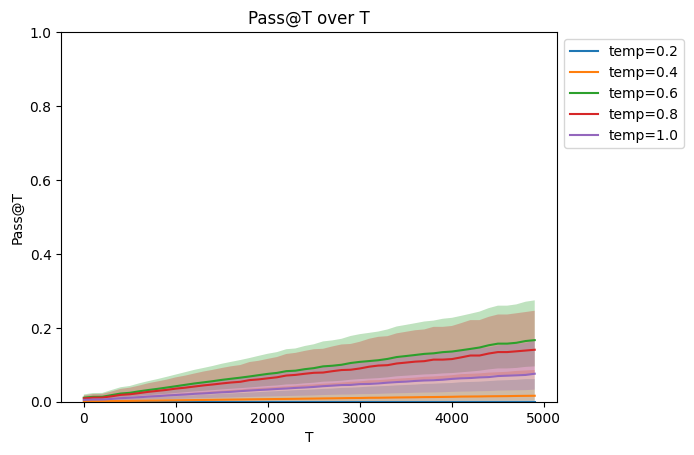

In [10]:
ts = np.arange(0, 5000, 100)

for temp in sorted(df["temp"].unique()):
    config_df = df[(df["temp"] == temp)]
    
    success_rates, lows, highs = [], [], []
    for t in ts:
        success_rate, low, high = compute_pass_at_t_and_ci(config_df, t)
        success_rates.append(success_rate)
        lows.append(low)
        highs.append(high)

    plt.plot(ts, success_rates, label=f"temp={temp}")
    plt.fill_between(ts, lows, highs, alpha=0.3)

plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.xlabel("T")
plt.ylabel("Pass@T")
plt.title("Pass@T over T")
plt.ylim(0,1)
plt.show()

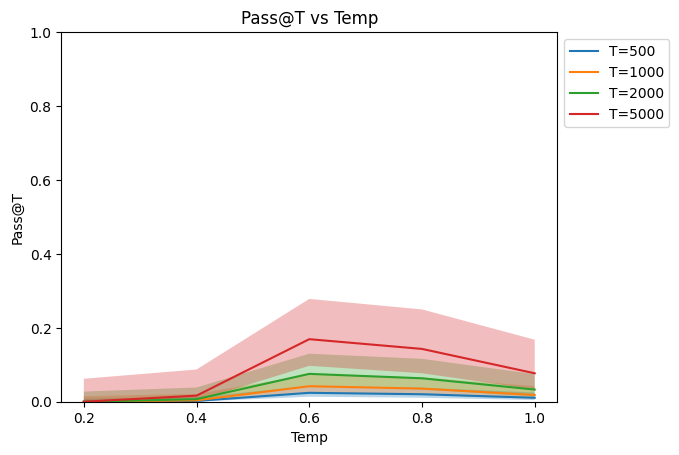

In [11]:
temps = sorted(df["temp"].unique())

for T in [500, 1000, 2000, 5000]:
    config_df = df
    success_rates, lows, highs = [], [], []
    for temp in temps:
        config_df_2 = config_df[config_df["temp"] == temp]
        if config_df_2.empty:
            success_rate, low, high = np.nan, np.nan, np.nan
        else:
            success_rate, low, high = compute_pass_at_t_and_ci(config_df_2, T)
        success_rates.append(success_rate)
        lows.append(low)
        highs.append(high)

    plt.plot(temps, success_rates, label=f"T={T}")
    plt.fill_between(temps, lows, highs, alpha=0.3)

plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.xlabel("Temp")
plt.ylabel(f"Pass@T")
plt.title(f"Pass@T vs Temp")
plt.ylim(0,1)
plt.show()

In [12]:
# Calculating whole program sampling pass at T (assuming all have same length and 1k samples) 

p = 0.02
n = 300
scores = np.random.binomial(1, p, size=1000)

In [13]:
successes = []
l = 0
T = 5000
for s in scores:
    l += n
    if s:
        successes.append(1)
        l = 0
    if l >= T:
        successes.append(0)
        l = 0
print(np.mean(successes))
print(len(successes))

0.2318840579710145
69


In [14]:
binomtest(sum(successes), len(successes)).proportion_ci(confidence_level=0.95, method="wilson")

ConfidenceInterval(low=0.1480790448607033, high=0.3439684704000926)